In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 10
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


In [3]:
def Denseblock(n):
    def f(x):
        activation = mish
        x = Dense(n)(x)
#         x = BatchNormalization()(x)
        x = Activation(activation)(x)
        
        return x
    return f

In [4]:
class GAN:
    def __init__(self, d_dim, latent_dim):
        # data structure
        self.d_dim = d_dim
        self.latent_dim = latent_dim
        
        self.convergence = []
        self.gamma=0.7
        
        # build model
        self.gen = self.build_generator()
        self.disc = self.build_discriminator()
        self.disc.compile(optimizer=optimizers.Adam(2e-4, 0.5), loss='binary_crossentropy', metrics=['acc'])
        # even though trainable = False, disc itself can be trained and it only affect gan model !!
        self.disc.trainable = False
        
        # combine generator and discriminator = GAN !!
        z = Input(shape = (self.latent_dim, ))
        self.gan = Model(z, self.disc(self.gen(z)), name='GAN')
        self.gan.compile(optimizer=optimizers.Adam(2e-4, 0.5), loss='binary_crossentropy')
        # there exists several strategy about models's optimizer, especially learning rate
        
    
    def build_generator(self):
        inputs = Input(shape = (self.latent_dim, ))
        
        x = Denseblock(256)(inputs)
        x = BatchNormalization()(x)
        x = Denseblock(512)(x)
        x = BatchNormalization()(x)
        x = Denseblock(1024)(x)
        
        outputs = Dense(self.d_dim[1], activation='tanh')(x)
        
        gen = Model(inputs, outputs, name='generator')
        
        return gen
    
    def build_discriminator(self):
        inputs = Input(shape = (self.d_dim[1], ))
        
        x = Denseblock(512)(inputs)
        x = Denseblock(256)(x)
        
        outputs = Dense(1, activation='sigmoid')(x)
        
        disc = Model(inputs, outputs, name='discriminator')
        
        return disc
    
    def train(self, x, epochs=10, batch_size=1024):
        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))
        for e in range(epochs+1):
            idx = np.random.randint(0, self.d_dim[0], batch_size)
            real = x[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            fake = self.gen.predict(noise)
            
            # train discriminator
            d_loss_real, d_acc_real = self.disc.train_on_batch(real, real_label)
            d_loss_fake, d_acc_fake = self.disc.train_on_batch(fake, fake_label)
            d_loss = 0.5*np.add(d_loss_fake, d_loss_real)

            # train generator
            g_loss = self.gan.train_on_batch(noise, real_label)
            
            m = d_loss + np.abs(self.gamma*d_loss_real - g_loss)
            self.convergence.append(m)
            
            if not e%500:
                print('epoch', e+1)
                self.sample_images()
                
    def sample_images(self):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r*c, 100))
        imgs = self.gen.predict(noise)*0.5 +0.5
        imgs = imgs.reshape(r*c, 28, 28)
        fig, axs = plt.subplots(r, c)
        n = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(imgs[n], cmap='gray')
                axs[i,j].axis('off')
                n += 1
        
        plt.show()
        plt.close()

In [5]:

# prepare data
from keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = train_X.reshape(-1, 28*28)

# build gan
d_dim = train_X.shape
gan = GAN(d_dim, 100)

Using TensorFlow backend.


epoch 1


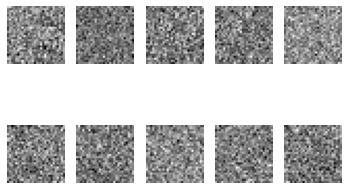

epoch 501


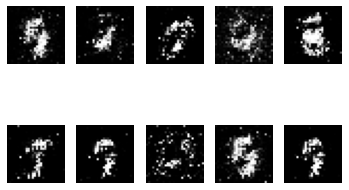

epoch 1001


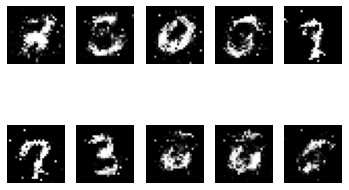

epoch 1501


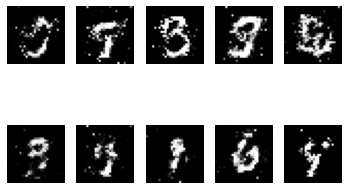

epoch 2001


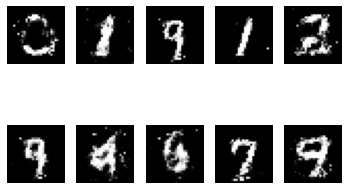

epoch 2501


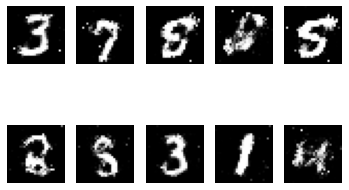

epoch 3001


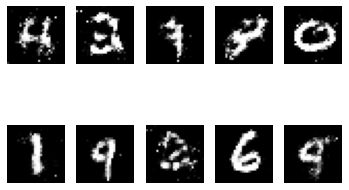

epoch 3501


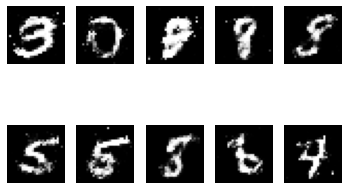

epoch 4001


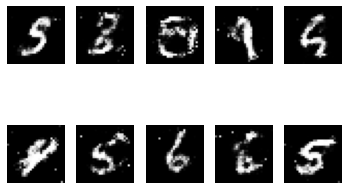

epoch 4501


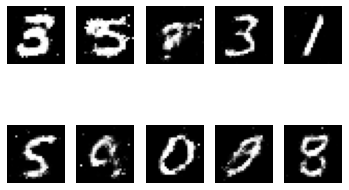

epoch 5001


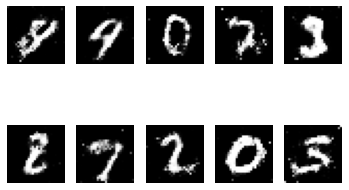

In [6]:
gan.train(train_X, 5000, 1024*2)

In [7]:
gan.gen.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               20

In [8]:
gan.disc.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_______________________________________________